In [1]:
import pandas as pd
import numpy as np

In [65]:
ratings = pd.read_csv(r"C:\Users\dza\Desktop\Diploma Thesis\Dataset\ml-32m\ratings.csv")
movies = pd.read_csv(r"C:\Users\dza\Desktop\Diploma Thesis\Dataset\ml-32m\movies.csv")

In [66]:
# Merge datasets on movieId column
df = ratings.merge(movies, on="movieId", how="left")

In [67]:
dup_pairs = df.duplicated(subset=['userId','movieId']).sum()
dup_pairs

np.int64(0)

In [19]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [21]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [28]:
ratings.shape

(32000204, 4)

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,17,4.0,944249077,Sense and Sensibility (1995),Drama|Romance
1,1,25,1.0,944250228,Leaving Las Vegas (1995),Drama|Romance
2,1,29,2.0,943230976,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
3,1,30,5.0,944249077,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
4,1,32,5.0,943228858,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


In [24]:
df.shape

(32000204, 7)

In [7]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [8]:
df.nunique()

userId         200948
movieId         84432
rating             10
timestamp    25976523
title           84239
genres           1783
dtype: int64

In [5]:
user_counts = ratings['userId'].value_counts().sort_values()
movie_counts = ratings['movieId'].value_counts().sort_values()

In [6]:
user_counts.head(5404)

userId
146604    20
83690     20
187748    20
164501    20
27913     20
          ..
30270     20
105793    20
116305    20
116298    20
72336     20
Name: count, Length: 5404, dtype: int64

In [7]:
movie_counts.head(44027)

movieId
228773    1
287651    1
287797    1
289293    1
290159    1
         ..
116588    5
202842    5
170062    5
87336     5
205982    5
Name: count, Length: 44027, dtype: int64

Now we need to normalize ratings to make them mean-centered per user
We will use Formula 2.3 from Diploma paper for this purpose

In [4]:
# We split dataset into train and test sets with 80 to 20 percent rule
# We make splitting for each user because we can have all user's ratings in train or test set if we will make the split on the whole dataset

from sklearn.model_selection import train_test_split

df = df.copy()

train_list = []
test_list = []

for user, group in df.groupby('userId'):
    train_g, test_g = train_test_split(
        group, 
        test_size=0.2,
        random_state=42
    )
    train_list.append(train_g)
    test_list.append(test_g)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

train_df

,userId,movieId,rating,timestamp,title,genres
0,1,2313,5.0,944253207,"Elephant Man, The (1980)",Drama
1,1,302,4.0,944253272,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance
2,1,307,5.0,944253207,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,161,1.0,943231162,Crimson Tide (1995),Drama|Thriller|War
4,1,923,5.0,944250228,Citizen Kane (1941),Drama|Mystery
...,...,...,...,...,...,...
25520892,200948,2997,4.0,1203427254,Being John Malkovich (1999),Comedy|Drama|Fantasy
25520893,200948,208,4.5,1203427388,Waterworld (1995),Action|Adventure|Sci-Fi
25520894,200948,2617,3.0,1203427715,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller
25520895,200948,34048,4.5,1203437999,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller


In [5]:
# Create filtered testing dataset for all models evaluations
min_ratings = 5

# Movies that are frequent enough in TRAIN
movie_counts_train = train_df['movieId'].value_counts()
valid_movies = movie_counts_train[movie_counts_train >= min_ratings].index

# Filter train/test by movies seen in train and frequent enough
filtered_train_df = train_df[train_df['movieId'].isin(valid_movies)].copy()
filtered_test_df  = test_df[test_df['movieId'].isin(valid_movies)].copy()

# Ensure warm-start by users too (important for MF)
valid_users = filtered_train_df['userId'].unique()
filtered_test_df = filtered_test_df[filtered_test_df['userId'].isin(valid_users)].copy()

filtered_train_df = filtered_train_df.reset_index(drop=True)
filtered_test_df  = filtered_test_df.reset_index(drop=True)

In [51]:
# USER-based centering (for user-based CF)
user_means = train_df.groupby('userId')['rating'].transform('mean')
train_df['user_ratings_centered'] = train_df['rating'] - user_means

# ITEM-based centering (for item-based CF)
item_means = filtered_train_df.groupby('movieId')['rating'].transform('mean')
filtered_train_df['item_ratings_centered'] = filtered_train_df['rating'] - item_means

In [6]:
eval_df = filtered_test_df.sample(n=500_000, random_state=42)

In [14]:
eval_df_200k = filtered_test_df.sample(n=200_000, random_state=42)

In [23]:
filtered_test_df.shape

(6456043, 7)

In [27]:
eval_df.shape

(500000, 7)

In [52]:
filtered_train_df

,userId,movieId,rating,timestamp,title,genres,item_ratings_centered
0,1,2313,5.0,944253207,"Elephant Man, The (1980)",Drama,1.078127
1,1,302,4.0,944253272,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.246088
2,1,307,5.0,944253207,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.024673
3,1,161,1.0,943231162,Crimson Tide (1995),Drama|Thriller|War,-2.744799
4,1,923,5.0,944250228,Citizen Kane (1941),Drama|Mystery,0.929436
...,...,...,...,...,...,...,...
25520892,200948,2997,4.0,1203427254,Being John Malkovich (1999),Comedy|Drama|Fantasy,0.068838
25520893,200948,208,4.5,1203427388,Waterworld (1995),Action|Adventure|Sci-Fi,1.611254
25520894,200948,2617,3.0,1203427715,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller,-0.227531
25520895,200948,34048,4.5,1203437999,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,1.339978


In [53]:
train_df

,userId,movieId,rating,timestamp,title,genres,user_ratings_centered
0,1,2313,5.0,944253207,"Elephant Man, The (1980)",Drama,1.366071
1,1,302,4.0,944253272,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.366071
2,1,307,5.0,944253207,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.366071
3,1,161,1.0,943231162,Crimson Tide (1995),Drama|Thriller|War,-2.633929
4,1,923,5.0,944250228,Citizen Kane (1941),Drama|Mystery,1.366071
...,...,...,...,...,...,...,...
25520892,200948,2997,4.0,1203427254,Being John Malkovich (1999),Comedy|Drama|Fantasy,0.393617
25520893,200948,208,4.5,1203427388,Waterworld (1995),Action|Adventure|Sci-Fi,0.893617
25520894,200948,2617,3.0,1203427715,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller,-0.606383
25520895,200948,34048,4.5,1203437999,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,0.893617


In [15]:
# Save the split to make sure that results are reproducible even if dataframe will change and to just load this split later (save my time)

# train_df.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\train_df.parquet", engine="pyarrow", index=False)
# test_df.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\test_df.parquet", engine="pyarrow", index=False)
filtered_test_df.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\filtered_test_df.parquet", engine="pyarrow", index=False)
# filtered_train_df.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\filtered_train_df.parquet", engine="pyarrow", index=False)
# eval_df.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\eval_df.parquet", engine="pyarrow", index=False)
eval_df_200k.to_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\eval_df_200k.parquet", engine="pyarrow", index=False)

In [2]:
# Load train_df and test_df
# train_df = pd.read_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\train_df.parquet")
filtered_test_df = pd.read_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\filtered_test_df.parquet")
filtered_train_df = pd.read_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\filtered_train_df.parquet")
eval_df_200k = pd.read_parquet(r"C:\Users\dza\Desktop\Diploma Thesis\Code\eval_df_200k.parquet")

In [15]:
test_df.shape

(6479307, 7)

In [3]:
train_df.nunique()

userId                200948
movieId                80213
rating                    10
timestamp           21180968
title                  80038
genres                  1767
ratings_centered      350227
dtype: int64

In [41]:
# Create mappings from training set

# global user index
user_id_map = {
    uid: idx
    for idx, uid in enumerate(train_df['userId'].unique())
}

# global movie index
movie_id_map = {
    mid: idx
    for idx, mid in enumerate(train_df['movieId'].unique())
}

n_users  = len(user_id_map)
n_movies = len(movie_id_map)

In [38]:
train_df['movieId'].unique()

array([  2313,    302,    307, ..., 175771, 157917, 274343],
      shape=(80213,))

In [40]:
movie_id_map[274343]

80212

In [37]:
user_id_map[1]

0

In [8]:
# My Own Ratings (Add 10 more to make it 20 like minimum number of ratings for each user)

my_ratings = pd.DataFrame({
    "userId": 999999,  # choose an ID not used in the dataset
    "movieId": [109487, 79132, 1682, 166024, 41569, 49530, 164909, 102407, 2571, 3535],
    "rating": [5, 5, 5, 4.5, 4.5, 4, 4, 3.5, 3.5, 3]
})

train_df = pd.concat([train_df, my_ratings], ignore_index=True)

train_df

,userId,movieId,rating,timestamp,title,genres,ratings_centered
0,1,2313,5.0,944253207.0,"Elephant Man, The (1980)",Drama,1.468085
1,1,302,4.0,944253272.0,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.468085
2,1,307,5.0,944253207.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.468085
3,1,161,1.0,943231162.0,Crimson Tide (1995),Drama|Thriller|War,-2.531915
4,1,923,5.0,944250228.0,Citizen Kane (1941),Drama|Mystery,1.468085
...,...,...,...,...,...,...,...
25520902,999999,49530,4.0,NaN,NaN,NaN,NaN
25520903,999999,164909,4.0,NaN,NaN,NaN,NaN
25520904,999999,102407,3.5,NaN,NaN,NaN,NaN
25520905,999999,2571,3.5,NaN,NaN,NaN,NaN


In [12]:
avg_rating = 4.2
mask = train_df['userId'] == 999999

train_df.loc[mask, 'ratings_centered'] = (train_df.loc[mask, 'rating'] - avg_rating)

In [13]:
train_df

,userId,movieId,rating,timestamp,title,genres,ratings_centered
0,1,2313,5.0,944253207.0,"Elephant Man, The (1980)",Drama,1.468085
1,1,302,4.0,944253272.0,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.468085
2,1,307,5.0,944253207.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.468085
3,1,161,1.0,943231162.0,Crimson Tide (1995),Drama|Thriller|War,-2.531915
4,1,923,5.0,944250228.0,Citizen Kane (1941),Drama|Mystery,1.468085
...,...,...,...,...,...,...,...
25520902,999999,49530,4.0,NaN,NaN,NaN,-0.200000
25520903,999999,164909,4.0,NaN,NaN,NaN,-0.200000
25520904,999999,102407,3.5,NaN,NaN,NaN,-0.700000
25520905,999999,2571,3.5,NaN,NaN,NaN,-0.700000


In [ ]:
# RUNTIME ESTIMATION (1%, 2%, 4%, 8% of the Dataset)

In [12]:
all_users = train_df['userId'].unique()
print(all_users)
n_users_ = len(all_users)
print("Total users:", n_users_)

[     1      2      3 ... 200946 200947 200948]
Total users: 200948


In [ ]:
# Function to create user based subsets

In [13]:
def create_user_subset(df, user_fraction, random_state=42):
    """
    Create a dataset with a given fraction of users, keeping all their ratings.
    """
    rng = np.random.default_rng(random_state)
    
    n_sampled = int(len(df['userId'].unique()) * user_fraction)
    sampled_users = rng.choice(
        df['userId'].unique(),
        size=n_sampled,
        replace=False
    )
    
    subset_df = df[df['userId'].isin(sampled_users)].copy()
    return subset_df

In [81]:
fractions = [0.01, 0.02, 0.04, 0.08, 0.16]

subsets = {}
for frac in fractions:
    subsets[f"{int(frac*100)}%"] = create_user_subset(train_df, frac)
    print(f"{int(frac*100)}% users:",
          subsets[f"{int(frac*100)}%"].shape)
print(subsets.keys())

1% users: (256571, 7)
2% users: (498802, 7)
4% users: (1020367, 7)
8% users: (2070861, 7)
16% users: (4128925, 7)
dict_keys(['1%', '2%', '4%', '8%', '16%'])


In [61]:
subsets["1%"]['userId'].unique()

array([   248,    308,    333, ..., 200294, 200581, 200880], shape=(2009,))

In [26]:
all_users = subsets["1%"]['userId'].unique()
n_users_ = len(all_users)
print("Total users:", n_users_)

Total users: 2009


In [84]:
import time
import psutil
import os
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

results = []

process = psutil.Process(os.getpid())

for label, subset_df in subsets.items():
    print(f"\nRunning experiment for {label} users")

    # build matrix
    sampled_users = subset_df['userId'].unique()
    local_user_map = {uid: i for i, uid in enumerate(sampled_users)}

    rows = subset_df['userId'].map(local_user_map).to_numpy()
    cols = subset_df['movieId'].map(movie_id_map).to_numpy()

    user_item_matrix = csr_matrix(
        (subset_df['ratings_centered'].to_numpy(), (rows, cols)),
        shape=(len(sampled_users), n_movies)
    )

    # local means aligned to local_user_map
    user_means_local = np.zeros(len(sampled_users), dtype=np.float32)
    for uid, idx in local_user_map.items():
        user_means_local[idx] = train_user_mean.get(uid, global_mean)
    
    print(f"\nStarting training part")
    start = time.perf_counter()
    mem_before = process.memory_info().rss / 1024**2

    knn = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1)
    knn.fit(user_item_matrix)

    distances, neighbors = knn.kneighbors(user_item_matrix)

    elapsed = time.perf_counter() - start
    mem_after = process.memory_info().rss / 1024**2

    test_sub = test_df[test_df.userId.isin(sampled_users)]
    
    print(f"\nStarting predicting part")
    start = time.perf_counter()

    preds = []

    for u, m in zip(test_sub.userId, test_sub.movieId):
        u_idx = local_user_map.get(u, None)
        if u_idx is None:
            preds.append(global_mean)
            continue
    
        m_idx = movie_id_map.get(m, None)
        if m_idx is None:
            preds.append(float(user_means_local[u_idx]))
            continue
            
        preds.append(
            predict_user_based(
                u_idx,
                m_idx,
                user_item_matrix,
                user_means_local,
                neighbors,
                distances
            )
        )

    elapsed_pred = time.perf_counter() - start

    results.append({
        "Users %": label,
        "Ratings": len(subset_df),
        "Training Time (s)": elapsed,
        "Prediction Time (s)": elapsed_pred,
        "Memory (MB)": mem_after - mem_before
    })

results_df = pd.DataFrame(results)
results_df


Running experiment for 1% users

Starting training part

Starting predicting part

Running experiment for 2% users

Starting training part

Starting predicting part

Running experiment for 4% users

Starting training part

Starting predicting part

Running experiment for 8% users

Starting training part

Starting predicting part

Running experiment for 16% users

Starting training part

Starting predicting part


,Users %,Ratings,Training Time (s),Prediction Time (s),Memory (MB)
0,1%,256571,0.255391,8.156529,-9.703125
1,2%,498802,1.054047,20.715976,3.773438
2,4%,1020367,4.493143,36.885217,6.070312
3,8%,2070861,16.900932,63.319804,0.371094
4,16%,4128925,79.784550,159.414733,26.355469


In [ ]:
# USER BASED COLLABORATIVE FILTERING

In [43]:
train_df

,userId,movieId,rating,timestamp,title,genres,user_ratings_centered
0,1,2313,5.0,944253207,"Elephant Man, The (1980)",Drama,1.366071
1,1,302,4.0,944253272,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.366071
2,1,307,5.0,944253207,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.366071
3,1,161,1.0,943231162,Crimson Tide (1995),Drama|Thriller|War,-2.633929
4,1,923,5.0,944250228,Citizen Kane (1941),Drama|Mystery,1.366071
...,...,...,...,...,...,...,...
25520892,200948,2997,4.0,1203427254,Being John Malkovich (1999),Comedy|Drama|Fantasy,0.393617
25520893,200948,208,4.5,1203427388,Waterworld (1995),Action|Adventure|Sci-Fi,0.893617
25520894,200948,2617,3.0,1203427715,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller,-0.606383
25520895,200948,34048,4.5,1203437999,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,0.893617


In [42]:
from scipy.sparse import csr_matrix

# Map IDs to continuous integers
user_ids = train_df['userId'].map(user_id_map).to_numpy()
movie_ids = train_df['movieId'].map(movie_id_map).to_numpy()

# Build sparse matrix
user_item_matrix = csr_matrix(
    (train_df['user_ratings_centered'], (user_ids, movie_ids)), shape=(n_users, n_movies)
)

In [49]:
# Find top K neighbors 

from sklearn.neighbors import NearestNeighbors
import time

k_params = [5, 10, 20]
results = []

for k in k_params:
    print(f"\nTraining started for k = {k}")
    start = time.perf_counter()
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute', n_jobs=-1)
    knn.fit(user_item_matrix)
    distances, neighbors = knn.kneighbors(user_item_matrix)
    train_time = time.perf_counter() - start

    np.save(rf"C:\Users\dza\Desktop\Diploma Thesis\Code\USER_BASED\neighbors_k{k}.npy", neighbors)
    np.save(rf"C:\Users\dza\Desktop\Diploma Thesis\Code\USER_BASED\distances_k{k}.npy", distances)

    print(f"Starting predictions for k = {k}")
    start = time.perf_counter()
    preds = []

    for u, m in zip(eval_df.userId, eval_df.movieId):
        u_idx = user_id_map.get(u, None)
        if u_idx is None:
            preds.append(global_mean)
            continue
    
        m_idx = movie_id_map.get(m, None)
        if m_idx is None:
            preds.append(float(user_means_vec[u_idx]))
            continue
            
        preds.append(
            predict_user_based(
                u_idx,
                m_idx,
                user_item_matrix,
                user_means_vec,
                neighbors,
                distances
            )
        )
    pred_time = time.perf_counter() - start

    # USER-BASED Evaluation
    rmse_user, mae_user = evaluate_model(eval_df.rating.values, np.array(preds))
    
    print(f"Training time (s):   {train_time:.3f}")
    print(f"Prediction time (s): {pred_time:.3f}")
    print(f"RMSE: {rmse_item:.5f}")
    print(f"MAE : {mae_item:.5f}")

    # Save interim results
    out_path = rf"C:\Users\dza\Desktop\Diploma Thesis\Code\USER_BASED\eval_preds_k{k}.csv"
    pd.DataFrame({
        "userId": eval_df.userId.values,
        "movieId": eval_df.movieId.values,
        "rating": eval_df.rating.values,
        f"pred_user_based_k{k}": preds
    }).to_csv(out_path, index=False)

    results.append({
        "k": k,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
        "rmse": rmse_user,
        "mae": mae_user
    })

summary_df = pd.DataFrame(results)
summary_df


Training started for k = 5
Starting predictions for k = 5
Training time (s):   3421.515
Prediction time (s): 98.059
RMSE: 0.81543
MAE : 0.60497

Training started for k = 10
Starting predictions for k = 10
Training time (s):   3423.087
Prediction time (s): 184.621
RMSE: 0.81543
MAE : 0.60497

Training started for k = 20
Starting predictions for k = 20
Training time (s):   3422.489
Prediction time (s): 361.418
RMSE: 0.81543
MAE : 0.60497


,k,train_time_s,pred_time_s,rmse,mae
0,5,3421.515396,98.059219,0.929791,0.705299
1,10,3423.086972,184.620734,0.917662,0.694432
2,20,3422.489354,361.418449,0.903095,0.682158


In [60]:
from sklearn.neighbors import NearestNeighbors

# Training the model with k=5
knn = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(user_item_matrix)

distances, neighbors = knn.kneighbors(user_item_matrix)

In [44]:
# Computing user_means vector with average ratings for each user
train_user_mean = train_df.groupby('userId')['rating'].mean()
user_means_vec = np.zeros(len(user_id_map), dtype=np.float32)
global_mean = float(train_df['rating'].mean())  # We can use global_mean just as a fallback

In [45]:
for uid, idx in user_id_map.items():
    # We create user_means vector using ratings only from training dataset
    user_means_vec[idx] = train_user_mean.get(uid, global_mean)

In [61]:
# Saving training results to not retrain the model later
import pickle
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\neighbors_k5.npy", neighbors)
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\distances_k5.npy", distances)
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\user_means.npy", user_means_vec)

with open(r"C:\Users\dza\Desktop\Diploma Thesis\Code\mappings.pkl", "wb") as f:
    pickle.dump({
        "user_id_map": user_id_map,
        "movie_id_map": movie_id_map
    }, f)

In [ ]:
# HOW TO LOAD THE DATA

# neighbors = np.load("neighbors_k5.npy")
# distances = np.load("distances_k5.npy")
# user_means_vec = np.load("user_means.npy")

# with open("mappings.pkl", "rb") as f:
#     maps = pickle.load(f)

In [47]:
# import numpy as np

def predict_user_based(u_idx, m_idx, user_item_mat, user_means_vec, neigh_idx, neigh_dist):
    weighted_sum = 0.0
    sim_sum = 0.0
    
    for neighbor, dist in zip(neigh_idx[u_idx], neigh_dist[u_idx]):
        # kneighbors return user id as the first ID in neighbors
        if u_idx == neighbor:
            continue
        sim = 1.0 - dist  # Cosine similarity is inverted distance

        # mean-centered rating since ratings in user-item matrix are already mean-centered (0 means "not rated")
        r = user_item_mat[neighbor, m_idx]
        if r != 0:
            weighted_sum += sim * float(r)
            sim_sum += abs(sim)

    if sim_sum == 0.0:
        return float(user_means_vec[u_idx])
    
    return float(user_means_vec[u_idx] + weighted_sum / sim_sum)

In [64]:
preds = []

for u, m in zip(filtered_test_df.userId, filtered_test_df.movieId):
    u_idx = user_id_map.get(u, None)
    if u_idx is None:
        preds.append(global_mean)
        continue

    m_idx = movie_id_map.get(m, None)
    if m_idx is None:
        preds.append(float(user_means_vec[u_idx]))
        continue
        
    preds.append(
        predict_user_based(
            u_idx,
            m_idx,
            user_item_matrix,
            user_means_vec,
            neighbors,
            distances
        )
    )

filtered_test_df["pred_user_based"] = preds

In [68]:
filtered_test_df

,userId,movieId,rating,timestamp,title,genres,pred_user_based
0,1,1234,5.0,944053948,"Sting, The (1973)",Comedy|Crime,4.546972
1,1,2232,3.0,943228696,Cube (1997),Horror|Mystery|Sci-Fi|Thriller,3.633929
2,1,908,5.0,944250228,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,3.633929
3,1,1178,4.0,943231162,Paths of Glory (1957),Drama|War,3.633929
4,1,1944,2.0,943231120,From Here to Eternity (1953),Drama|Romance|War,3.633929
...,...,...,...,...,...,...,...
6479302,200948,1485,3.5,1203437919,Liar Liar (1997),Comedy,3.606383
6479303,200948,50798,0.5,1203426424,Epic Movie (2007),Adventure|Comedy,3.606383
6479304,200948,79702,4.5,1294412589,Scott Pilgrim vs. the World (2010),Action|Comedy|Fantasy|Musical|Romance,3.606383
6479305,200948,2353,3.0,1203438980,Enemy of the State (1998),Action|Thriller,3.714817


In [66]:
filtered_test_df.to_csv(r"C:\Users\dza\Desktop\Diploma Thesis\Code\test_df_preds_k5.csv", index=False)

In [69]:
filtered_test_df_ = pd.read_csv(r"C:\Users\dza\Desktop\Diploma Thesis\Code\test_df_preds_k5.csv")
filtered_test_df_

,userId,movieId,rating,timestamp,title,genres,pred_user_based
0,1,1234,5.0,944053948,"Sting, The (1973)",Comedy|Crime,4.546972
1,1,2232,3.0,943228696,Cube (1997),Horror|Mystery|Sci-Fi|Thriller,3.633929
2,1,908,5.0,944250228,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,3.633929
3,1,1178,4.0,943231162,Paths of Glory (1957),Drama|War,3.633929
4,1,1944,2.0,943231120,From Here to Eternity (1953),Drama|Romance|War,3.633929
...,...,...,...,...,...,...,...
6456038,200948,1485,3.5,1203437919,Liar Liar (1997),Comedy,3.606383
6456039,200948,50798,0.5,1203426424,Epic Movie (2007),Adventure|Comedy,3.606383
6456040,200948,79702,4.5,1294412589,Scott Pilgrim vs. the World (2010),Action|Comedy|Fantasy|Musical|Romance,3.606383
6456041,200948,2353,3.0,1203438980,Enemy of the State (1998),Action|Thriller,3.714817


In [38]:
from scipy.sparse import csr_matrix

row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
m = csr_matrix((data, (row, col)), shape=(3, 3))
print(m.data)

[1 2 3 4 5 6]


In [85]:
n_users

200948

In [43]:
user_ids

array([     0,      0,      0, ..., 200947, 200947, 200947],
      shape=(25520897,))

In [45]:
movie_ids

array([   0,    1,    2, ...,  238, 1595,  179], shape=(25520897,))

In [44]:
train_df['userId']

0                1
1                1
2                1
3                1
4                1
             ...  
25520892    200948
25520893    200948
25520894    200948
25520895    200948
25520896    200948
Name: userId, Length: 25520897, dtype: int64

In [46]:
train_df['movieId']

0            2313
1             302
2             307
3             161
4             923
            ...  
25520892     2997
25520893      208
25520894     2617
25520895    34048
25520896     2858
Name: movieId, Length: 25520897, dtype: int64

In [15]:
# from annoy import AnnoyIndex
# from sklearn.decomposition import TruncatedSVD

# k = 20
# n_comps = 100

# # Reduce dimensions
# svd = TruncatedSVD(n_components=n_comps)
# user_vectors = svd.fit_transform(user_item_matrix)  # dense matrix now

# n_users, n_dims = user_vectors.shape
# ann = AnnoyIndex(n_dims, metric='angular')

# for i in range(n_users):
#     ann.add_item(i, user_vectors[i])

# ann.build(50)  # 50 trees for better accuracy

# user_neighbors = []
# user_sims = []
# for i in range(user_vectors.shape[0]):
#     idxs, dists = ann.get_nns_by_item(i, k, include_distances=True)
#     user_neighbors.append(idxs)
#     user_sims.append([1 - d/2 for d in dists]) 

In [72]:
user_means_vec

array([3.6339285, 4.3414636, 3.5982907, ..., 4.388889 , 3.9166667,
       3.606383 ], shape=(200948,), dtype=float32)

In [18]:
len(test_df)

6479307

In [20]:
test_df = test_df.sample(50000, random_state=42)

In [ ]:
# ITEM BASED COLLABORATIVE FILTERING

In [13]:
filtered_train_df.nunique()

userId                     200948
movieId                     40080
rating                         10
timestamp                21127233
title                       40028
genres                       1533
item_ratings_centered      115139
dtype: int64

In [5]:
filtered_train_df.head()

,userId,movieId,rating,timestamp,title,genres,item_ratings_centered
0,1,2313,5.0,944253207,"Elephant Man, The (1980)",Drama,1.078127
1,1,302,4.0,944253272,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance,0.246088
2,1,307,5.0,944253207,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,1.024673
3,1,161,1.0,943231162,Crimson Tide (1995),Drama|Thriller|War,-2.744799
4,1,923,5.0,944250228,Citizen Kane (1941),Drama|Mystery,0.929436


In [7]:
movie_counts = filtered_train_df['movieId'].value_counts().sort_values()

In [8]:
movie_counts.head()

movieId
203533    5
151791    5
142981    5
125045    5
156710    5
Name: count, dtype: int64

In [9]:
# Create mappings from filtered training set

# global user index
user_id_map = {
    uid: idx
    for idx, uid in enumerate(filtered_train_df['userId'].unique())
}

# global movie index
movie_id_map = {
    mid: idx
    for idx, mid in enumerate(filtered_train_df['movieId'].unique())
}

n_users  = len(user_id_map)
n_movies = len(movie_id_map)

In [11]:
# Build item_user CSR matrix

from scipy.sparse import csr_matrix

# Map IDs to continuous integers
user_ids = filtered_train_df['userId'].map(user_id_map).to_numpy()
movie_ids = filtered_train_df['movieId'].map(movie_id_map).to_numpy()

# Sparse matrix
item_user_matrix = csr_matrix(
    (filtered_train_df['item_ratings_centered'], (movie_ids, user_ids)), shape=(n_movies, n_users)
)

In [31]:
print(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\neighbors_k" + str(10) + ".npy")

C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\neighbors_k10.npy


In [35]:
eval_df["rat" + "ing"]

4699316    2.5
3505936    3.5
263644     5.0
576849     4.5
1147691    2.5
          ... 
6023036    5.0
2471509    3.5
2296644    4.0
5024478    4.5
4930661    3.0
Name: rating, Length: 500000, dtype: float64

In [36]:
# Find top K neighbors 

from sklearn.neighbors import NearestNeighbors
import time

k_params = [10, 20, 50]
results = []

for k in k_params:
    print(f"\nTraining started for k = {k}")
    start = time.perf_counter()
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute', n_jobs=-1)
    knn.fit(item_user_matrix)
    distances, neighbors = knn.kneighbors(item_user_matrix)
    train_time = time.perf_counter() - start

    np.save(rf"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\neighbors_k{k}.npy", neighbors)
    np.save(rf"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\distances_k{k}.npy", distances)

    print(f"Starting predictions for k = {k}")
    start = time.perf_counter()
    preds = []

    for u, m in zip(eval_df.userId, eval_df.movieId):
        u_idx = user_id_map.get(u, None)
        if u_idx is None:
            preds.append(global_mean)
            continue
    
        m_idx = movie_id_map.get(m, None)
        if m_idx is None:
            preds.append(global_mean)
            continue
            
        preds.append(
            predict_item_based(
                u_idx,
                m_idx,
                item_user_matrix,
                item_means_vec,
                neighbors,
                distances
            )
        )
    pred_time = time.perf_counter() - start

    # ITEM-BASED Evaluation
    rmse_item, mae_item = evaluate_model(eval_df.rating.values, np.array(preds))
    
    print(f"Training time (s):   {train_time:.3f}")
    print(f"Prediction time (s): {pred_time:.3f}")
    print(f"RMSE: {rmse_item:.5f}")
    print(f"MAE : {mae_item:.5f}")

    # Save interim results
    out_path = rf"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\eval_preds_k{k}.csv"
    pd.DataFrame({
        "userId": eval_df.userId.values,
        "movieId": eval_df.movieId.values,
        "rating": eval_df.rating.values,
        f"pred_item_based_k{k}": preds
    }).to_csv(out_path, index=False)

    results.append({
        "k": k,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
        "rmse": rmse_item,
        "mae": mae_item
    })

summary_df = pd.DataFrame(results)
summary_df


Training started for k = 10
Starting predictions for k = 10
Training time (s):   162.703
Prediction time (s): 304.981
RMSE: 0.86701
MAE : 0.63853

Training started for k = 20
Starting predictions for k = 20
Training time (s):   161.568
Prediction time (s): 599.719
RMSE: 0.83896
MAE : 0.61891

Training started for k = 50
Starting predictions for k = 50
Training time (s):   141.144
Prediction time (s): 1460.639
RMSE: 0.81543
MAE : 0.60497


NameError: name 'rows_out' is not defined

In [37]:
summary_df = pd.DataFrame(results)
summary_df

,k,train_time_s,pred_time_s,rmse,mae
0,10,162.702708,304.981011,0.867008,0.638527
1,20,161.568394,599.719182,0.838956,0.618906
2,50,141.144172,1460.639225,0.815431,0.604972


In [ ]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(item_user_matrix)

distances, neighbors = knn.kneighbors(item_user_matrix)

In [14]:
# Computing item_means vector with average ratings for each movie
train_item_mean = filtered_train_df.groupby('movieId')['rating'].mean()
item_means_vec = np.zeros(len(movie_id_map), dtype=np.float32)
global_mean = float(filtered_train_df['rating'].mean())  # We can use global_mean just as a fallback

for mid, idx in movie_id_map.items():
    # We create item_means vector using ratings only from training dataset
    item_means_vec[idx] = train_item_mean.get(mid, global_mean)

In [15]:
# Saving training results to not retrain the model later
import pickle
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\neighbors_k5.npy", neighbors)
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\distances_k5.npy", distances)
np.save(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\item_means.npy", item_means_vec)

with open(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\mappings.pkl", "wb") as f:
    pickle.dump({
        "user_id_map": user_id_map,
        "movie_id_map": movie_id_map
    }, f)

In [16]:
def predict_item_based(u_idx, m_idx, item_user_mat, item_means_vec, neigh_idx, neigh_dist):
    weighted_sum = 0.0
    sim_sum = 0.0
    
    for neighbor, dist in zip(neigh_idx[m_idx], neigh_dist[m_idx]):
        # kneighbors returns id of iself as the first ID in neighbors
        if m_idx == neighbor:
            continue
        sim = 1.0 - dist  # Cosine similarity is inverted distance

        # mean-centered rating since ratings in item-user matrix are already mean-centered (0 means "not rated")
        r = item_user_mat[neighbor, u_idx]
        if r != 0:
            weighted_sum += sim * float(r)
            sim_sum += abs(sim)

    if sim_sum == 0.0:
        return float(item_means_vec[m_idx])
    
    return float(item_means_vec[m_idx] + weighted_sum / sim_sum)

In [18]:
preds = []

for u, m in zip(filtered_test_df.userId, filtered_test_df.movieId):
    u_idx = user_id_map.get(u, None)
    if u_idx is None:
        preds.append(global_mean)
        continue

    m_idx = movie_id_map.get(m, None)
    if m_idx is None:
        preds.append(global_mean)
        continue
        
    preds.append(
        predict_item_based(
            u_idx,
            m_idx,
            item_user_matrix,
            item_means_vec,
            neighbors,
            distances
        )
    )

filtered_test_df["pred_item_based"] = preds

In [19]:
filtered_test_df

,userId,movieId,rating,timestamp,title,genres,pred_item_based
0,1,1234,5.0,944053948,"Sting, The (1973)",Comedy|Crime,3.366149
1,1,2232,3.0,943228696,Cube (1997),Horror|Mystery|Sci-Fi|Thriller,3.584221
2,1,908,5.0,944250228,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,1.994022
3,1,1178,4.0,943231162,Paths of Glory (1957),Drama|War,4.185348
4,1,1944,2.0,943231120,From Here to Eternity (1953),Drama|Romance|War,3.919374
...,...,...,...,...,...,...,...
6456038,200948,1485,3.5,1203437919,Liar Liar (1997),Comedy,4.526962
6456039,200948,50798,0.5,1203426424,Epic Movie (2007),Adventure|Comedy,0.317212
6456040,200948,79702,4.5,1294412589,Scott Pilgrim vs. the World (2010),Action|Comedy|Fantasy|Musical|Romance,4.394386
6456041,200948,2353,3.0,1203438980,Enemy of the State (1998),Action|Thriller,3.576218


In [20]:
filtered_test_df.to_csv(r"C:\Users\dza\Desktop\Diploma Thesis\Code\ITEM_BASED\test_df_preds_k5.csv", index=False)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

def evaluate_model(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return rmse, mae

In [70]:
# USER-BASED Evaluation
rmse_user, mae_user = evaluate_model(
    filtered_test_df.rating.values,
    filtered_test_df.pred_user_based.values
)

print("User-based CF:")
print("  RMSE:", rmse_user)
print("  MAE :", mae_user)

User-based CF:
  RMSE: 0.9333413572618828
  MAE : 0.7085211473596146


In [22]:
# ITEM-BASED Evaluation
rmse_item, mae_item = evaluate_model(
    filtered_test_df.rating.values,
    filtered_test_df.pred_item_based.values
)

print("\nItem-based CF:")
print("  RMSE:", rmse_item)
print("  MAE :", mae_item)


Item-based CF:
  RMSE: 0.9072293092824026
  MAE : 0.6697734656978496


In [33]:
# from sklearn.decomposition import TruncatedSVD
# from annoy import AnnoyIndex

# n_comps = 100
# svd = TruncatedSVD(n_components=n_comps)

# item_vectors = svd.fit_transform(user_item_matrix.T)  # item × features

In [34]:
# n_items, n_dims = item_vectors.shape

# ann_items = AnnoyIndex(n_dims, metric='angular')

# for i in range(n_items):
#     ann_items.add_item(i, item_vectors[i])

# ann_items.build(50)

True

In [35]:
# K = 20

# item_neighbors = []
# item_sims = []

# for i in range(n_items):
#     idxs, dists = ann_items.get_nns_by_item(i, K, include_distances=True)
#     item_neighbors.append(idxs)
#     item_sims.append([1 - d/2 for d in dists])  # Annoy angular → similarity

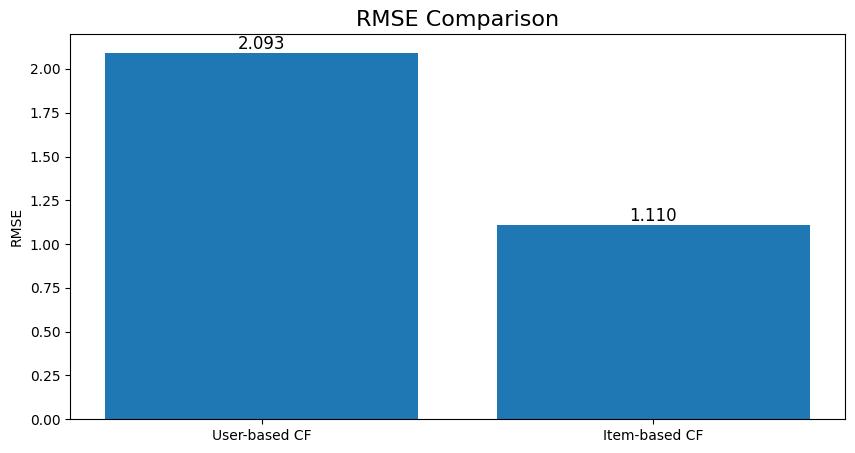

In [43]:
import matplotlib.pyplot as plt

models = ['User-based CF', 'Item-based CF']
rmse_values = [rmse_user, rmse_item]
mae_values  = [mae_user, mae_item]

plt.figure(figsize=(10, 5))
plt.title("RMSE Comparison", fontsize=16)

plt.bar(models, rmse_values)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=12)

plt.ylabel("RMSE")
plt.show()

In [70]:
# Find the row where 'Title' is 'Inception'
target_title = 'Inception (2010)'
result_row = movies.loc[movies['movieId'] == 3535]

print(result_row)

      movieId                   title                         genres
3437     3535  American Psycho (2000)  Crime|Horror|Mystery|Thriller


In [66]:
my_ratings = pd.DataFrame({
    "userId": 999999,  # choose an ID not used in the dataset
    "movieId": [109487, 79132, 1682, 166024, 41569, 49530, 164909, 102407, 2571, 3535],
    "rating": [5, 5, 5, 4.5, 4.5, 4, 4, 3.5, 3.5, 3]
})

In [25]:
my_uid = 999999
my_idx = user_id_to_index[my_uid]

In [40]:
candidate_movies = [
    movie for movie in movie_id_to_index.keys()
    if movie not in my_ratings["movieId"].values
]

recs = []
for m in candidate_movies:
    m_idx = movie_id_to_index[m]
    pred = fast_predict_item_based(
        my_idx,
        m_idx,
        user_item_matrix,
        item_neighbors,
        item_sims
    )
    recs.append((m, pred))

# sort by predicted rating
recs_sorted = sorted(recs, key=lambda x: x[1], reverse=True)[:100]

In [61]:
# sort by predicted rating
recs_sorted = sorted(recs, key=lambda x: x[1], reverse=True)[:1000]

In [62]:
recommendations = (
    pd.DataFrame(recs_sorted, columns=["movieId", "pred_rating"])
      .merge(movies, on="movieId", how="left")
)

In [63]:
recommendations['year_extracted'] = recommendations['title'].str.extract(r'\((\d{4})\)')
recommendations['year_extracted'] = pd.to_numeric(recommendations['year_extracted'], errors='coerce').astype('Int64')

# # Sort by the new numeric year column
recommendations_sorted = recommendations.sort_values(by='year_extracted', ascending=False)

In [7]:
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union
import math
import random
import time

Rating = Tuple[Union[int, str], Union[int, str], float]  # (user_id, item_id, rating)

class BiasedMF:
    """
    Biased Matrix Factorization using SGD.

    Parameters
    ----------
    n_factors : int
        Latent dimension k
    lr : float
        Learning rate
    reg : float
        L2 regularization strength
    n_epochs : int
        Number of passes over the training set
    seed : int
        Random seed for reproducibility
    init_std : float
        Std-dev for normal initialization of factors
    """

    def __init__(
        self,
        n_factors: int = 50,
        lr: float = 0.005,
        reg: float = 0.02,
        n_epochs: int = 20,
        seed: int = 42,
        init_std: float = 0.1,
        verbose: bool = True,
    ) -> None:
        if n_factors <= 0:
            raise ValueError("n_factors must be positive.")
        self.n_factors = int(n_factors)
        self.lr = float(lr)
        self.reg = float(reg)
        self.n_epochs = int(n_epochs)
        self.seed = int(seed)
        self.init_std = float(init_std)
        self.verbose = bool(verbose)

        # Learned parameters (initialized in fit)
        self.mu: float = 0.0
        self.user_map: Dict[Union[int, str], int] = {}
        self.item_map: Dict[Union[int, str], int] = {}
        self.user_inv: List[Union[int, str]] = []
        self.item_inv: List[Union[int, str]] = []

        self.P: Optional[np.ndarray] = None  # shape: (n_users, k)
        self.Q: Optional[np.ndarray] = None  # shape: (n_items, k)
        self.bu: Optional[np.ndarray] = None  # shape: (n_users,)
        self.bi: Optional[np.ndarray] = None  # shape: (n_items,)

        self._rng = np.random.default_rng(self.seed)

    # ---------------------------
    # ID mapping / initialization
    # ---------------------------

    def _to_index_arrays(self, train_df, eval_df=None):
        # Factorize TRAIN only
        u_codes, u_uniques = pd.factorize(train_df["userId"], sort=False)
        i_codes, i_uniques = pd.factorize(train_df["movieId"], sort=False)
    
        r = train_df["rating"].to_numpy(dtype=np.float32)
        u = u_codes.astype(np.int32, copy=False)
        i = i_codes.astype(np.int32, copy=False)
    
        # Store mappings in the model (so predict/recommend works)
        self.user_inv = list(u_uniques)
        self.item_inv = list(i_uniques)
        self.user_map = {uid: idx for idx, uid in enumerate(self.user_inv)}
        self.item_map = {mid: idx for idx, mid in enumerate(self.item_inv)}
    
        if eval_df is None:
            return (u, i, r), None
    
        eu = eval_df["userId"].map(self.user_map).to_numpy()
        ei = eval_df["movieId"].map(self.item_map).to_numpy()
        er = eval_df["rating"].to_numpy(dtype=np.float32)
    
        # Warm-start only: drop unknown users/items
        mask = (~pd.isna(eu)) & (~pd.isna(ei))
        eu = eu[mask].astype(np.int32, copy=False)
        ei = ei[mask].astype(np.int32, copy=False)
        er = er[mask].astype(np.float32, copy=False)
    
        return (u, i, r), (eu, ei, er)

    def _init_params(self) -> None:
        n_users = len(self.user_map)
        n_items = len(self.item_map)

        self.P = self._rng.normal(0.0, self.init_std, size=(n_users, self.n_factors)).astype(np.float32)
        self.Q = self._rng.normal(0.0, self.init_std, size=(n_items, self.n_factors)).astype(np.float32)
        self.bu = np.zeros(n_users, dtype=np.float32)
        self.bi = np.zeros(n_items, dtype=np.float32)

    # Checkpoints
    def save_checkpoint(self, path: str):
        np.savez_compressed(
            path,
            mu=self.mu,
            bu=self.bu,
            bi=self.bi,
            P=self.P,
            Q=self.Q,
            user_inv=np.array(self.user_inv, dtype=object),
            item_inv=np.array(self.item_inv, dtype=object),
            best_epoch=getattr(self, "best_epoch_", None),
            best_val_rmse=getattr(self, "best_val_rmse_", None),
            n_factors=self.n_factors,
            lr=self.lr,
            reg=self.reg,
        )

    def load_checkpoint(self, path: str):
        import numpy as np
    
        data = np.load(path, allow_pickle=True)
    
        self.mu = float(data["mu"])
        self.bu = data["bu"]
        self.bi = data["bi"]
        self.P = data["P"]
        self.Q = data["Q"]
    
        self.user_inv = list(data["user_inv"])
        self.item_inv = list(data["item_inv"])
        self.user_map = {u: i for i, u in enumerate(self.user_inv)}
        self.item_map = {i: j for j, i in enumerate(self.item_inv)}
    
        self.best_epoch_ = data.get("best_epoch", None)
        self.best_val_rmse_ = data.get("best_val_rmse", None)

    # ---------------------------
    # Core prediction helpers
    # ---------------------------

    def _check_fitted(self) -> None:
        if self.P is None or self.Q is None or self.bu is None or self.bi is None:
            raise RuntimeError("Model is not fitted yet. Call fit() first.")

    def _known_user_item(self, user_id: Union[int, str], item_id: Union[int, str]) -> Tuple[Optional[int], Optional[int]]:
        u = self.user_map.get(user_id)
        i = self.item_map.get(item_id)
        return u, i

    def predict(self, user_id: Union[int, str], item_id: Union[int, str], clip: Tuple[float, float] = (0.5, 5.0)) -> float:
        """
        Predict rating for (user_id, item_id).
        For unknown user or item: fallback to mu + known bias if available.

        clip: clamp prediction to rating scale (MovieLens: 0.5..5.0)
        """
        self._check_fitted()
        u_idx, i_idx = self._known_user_item(user_id, item_id)

        pred = self.mu
        if u_idx is not None:
            pred += float(self.bu[u_idx])
        if i_idx is not None:
            pred += float(self.bi[i_idx])
        if u_idx is not None and i_idx is not None:
            pred += float(np.dot(self.P[u_idx], self.Q[i_idx]))

        lo, hi = clip
        if lo is not None and pred < lo:
            pred = lo
        if hi is not None and pred > hi:
            pred = hi
        return float(pred)

    # ---------------------------
    # Training / evaluation
    # ---------------------------

    def fit(self, train_ratings, val_ratings=None, patience=2) -> "BiasedMF":
        """
        Fit model with SGD.

        train_ratings: list of (user_id, item_id, rating)
        val_ratings: optional validation set
        """
        print(f"Training is starting with parameters {self.n_factors}, {self.lr}, {self.reg}, {self.n_epochs}")
        if len(train_ratings) == 0:
            raise ValueError("train_ratings is empty.")

        # Build maps only from training data
        (u, i, r), val_tuple = self._to_index_arrays(train_ratings, val_ratings)

        # Global mean on training
        self.mu = float(r.mean())

        self._init_params()

        idx = np.arange(len(r), dtype=np.int32)

        best_val_rmse = np.inf
        best_epoch = 0
        epochs_without_improvement = 0
    
        # To restore best model
        best_state = None

        # SGD
        for epoch in range(1, self.n_epochs + 1):
            print(f"Epoch number {epoch} started:\n")
            start = time.perf_counter()
            self._rng.shuffle(idx)

            for t in idx:
                uu = u[t]
                ii = i[t]
                rr = r[t]
    
                # prediction
                pred = self.mu + self.bu[uu] + self.bi[ii] + float(np.dot(self.P[uu], self.Q[ii]))
                err = rr - pred
    
                # IMPORTANT: avoid .copy() allocations
                pu = self.P[uu]
                qi = self.Q[ii]
    
                # store old pu (as a small copy) ONLY if needed
                pu_old = pu.copy()
    
                # biases
                self.bu[uu] += self.lr * (err - self.reg * self.bu[uu])
                self.bi[ii] += self.lr * (err - self.reg * self.bi[ii])
    
                # factors
                pu += self.lr * (err * qi - self.reg * pu)
                qi += self.lr * (err * pu_old - self.reg * qi)

            print(f"Time to finish epoch number {epoch}: {time.perf_counter() - start} s")

            if val_tuple is not None:
                eu, ei, er = val_tuple
                val_rmse, val_mae = self._eval_arrays(eu, ei, er)
                if self.verbose:
                    print(f"Epoch {epoch:02d}/{self.n_epochs} | val RMSE {val_rmse:.5f} MAE {val_mae:.5f} ")

                # Early stopping if no improvement
                if val_rmse < best_val_rmse - 1e-3:
                    best_val_rmse = val_rmse
                    best_epoch = epoch
                    epochs_without_improvement = 0
    
                    # Save best model state
                    best_state = (
                        self.bu.copy(),
                        self.bi.copy(),
                        self.P.copy(),
                        self.Q.copy(),
                    )

                    # Save to disk
                    self.save_checkpoint(r"C:\Users\dza\Desktop\Diploma Thesis\Code\MF\best_model.npz")
                else:
                    epochs_without_improvement += 1
    
                    if epochs_without_improvement >= patience:
                        if self.verbose:
                            print(
                                f"Early stopping at epoch {epoch}. "
                                f"Best RMSE={best_val_rmse:.5f} at epoch {best_epoch}."
                            )
                        break
            else:
                if self.verbose:
                    print(f"Epoch {epoch:02d}/{self.n_epochs} done")

        return self

    def _eval_arrays(self, u, i, r, clip=(0.5, 5.0)):
        preds = self.mu + self.bu[u] + self.bi[i] + np.sum(self.P[u] * self.Q[i], axis=1)
        lo, hi = clip
        preds = np.clip(preds, lo, hi)
    
        err = r - preds
        rmse = float(np.sqrt(np.mean(err * err)))
        mae = float(np.mean(np.abs(err)))
        return rmse, mae

In [10]:
model = BiasedMF(
    n_factors=20,
    lr=0.005,
    reg=0.02,
    n_epochs=25,
    seed=42,
    verbose=True,
)
model.fit(filtered_train_df, eval_df_200k)

Training is starting with parameters 20, 0.005, 0.02, 25
Epoch number 1 started:

Time to finish epoch number 1: 373.4189844999928 s
Epoch 01/25 | val RMSE 0.87766 MAE 0.67077 
Epoch number 2 started:

Time to finish epoch number 2: 388.51296910014935 s
Epoch 02/25 | val RMSE 0.86632 MAE 0.66107 
Epoch number 3 started:

Time to finish epoch number 3: 385.1186028998345 s
Epoch 03/25 | val RMSE 0.85968 MAE 0.65514 
Epoch number 4 started:

Time to finish epoch number 4: 380.0765034998767 s
Epoch 04/25 | val RMSE 0.84922 MAE 0.64649 
Epoch number 5 started:

Time to finish epoch number 5: 364.46188200009055 s
Epoch 05/25 | val RMSE 0.83926 MAE 0.63810 
Epoch number 6 started:

Time to finish epoch number 6: 371.4189146000426 s
Epoch 06/25 | val RMSE 0.83134 MAE 0.63169 
Epoch number 7 started:

Time to finish epoch number 7: 377.07177779986523 s
Epoch 07/25 | val RMSE 0.82317 MAE 0.62509 
Epoch number 8 started:

Time to finish epoch number 8: 370.2072946000844 s
Epoch 08/25 | val RMSE 0

In [13]:
model = BiasedMF(
    n_factors=50,
    lr=0.005,
    reg=0.02,
    n_epochs=25,
    seed=42,
    verbose=True,
)
model.fit(filtered_train_df, filtered_test_df)

Training is starting with parameters 50, 0.005, 0.02, 25
Epoch number 1 started:

Time to finish epoch number 1: 456.47190320002846 s
Epoch 01/25 | val RMSE 0.87790 MAE 0.67100 
Epoch number 2 started:

Time to finish epoch number 2: 442.5656171999872 s
Epoch 02/25 | val RMSE 0.86571 MAE 0.66024 
Epoch number 3 started:

Time to finish epoch number 3: 360.2321003000252 s
Epoch 03/25 | val RMSE 0.85543 MAE 0.65157 
Epoch number 4 started:

Time to finish epoch number 4: 379.22568889986724 s
Epoch 04/25 | val RMSE 0.84394 MAE 0.64170 
Epoch number 5 started:

Time to finish epoch number 5: 422.03196679987013 s
Epoch 05/25 | val RMSE 0.83451 MAE 0.63384 
Epoch number 6 started:

Time to finish epoch number 6: 371.4378163001966 s
Epoch 06/25 | val RMSE 0.82528 MAE 0.62634 
Epoch number 7 started:

Time to finish epoch number 7: 359.5968222999945 s
Epoch 07/25 | val RMSE 0.81656 MAE 0.61932 
Epoch number 8 started:

Time to finish epoch number 8: 396.65555899986066 s
Epoch 08/25 | val RMSE 

In [9]:
learning_rates = [0.003, 0.008]
regs = [0.01, 0.05]

for reg in regs:
    model = BiasedMF(
        n_factors=50,
        lr=0.005,
        reg=reg,
        n_epochs=25,
        seed=42,
        verbose=True,
    )
    model.fit(filtered_train_df, eval_df_200k)

Training is starting with parameters 50, 0.005, 0.01, 25
Epoch number 1 started:

Time to finish epoch number 1: 358.5818019999424 s
Epoch 01/25 | val RMSE 0.87825 MAE 0.67123 
Epoch number 2 started:

Time to finish epoch number 2: 357.9882876999909 s
Epoch 02/25 | val RMSE 0.86479 MAE 0.65962 
Epoch number 3 started:

Time to finish epoch number 3: 364.5638501000358 s
Epoch 03/25 | val RMSE 0.85002 MAE 0.64738 
Epoch number 4 started:

Time to finish epoch number 4: 351.6071518000681 s
Epoch 04/25 | val RMSE 0.83576 MAE 0.63548 
Epoch number 5 started:

Time to finish epoch number 5: 360.20824349997565 s
Epoch 05/25 | val RMSE 0.82313 MAE 0.62520 
Epoch number 6 started:

Time to finish epoch number 6: 356.0444731999887 s
Epoch 06/25 | val RMSE 0.81214 MAE 0.61612 
Epoch number 7 started:

Time to finish epoch number 7: 364.0213548000902 s
Epoch 07/25 | val RMSE 0.80272 MAE 0.60849 
Epoch number 8 started:

Time to finish epoch number 8: 353.73666489997413 s
Epoch 08/25 | val RMSE 0.

In [ ]:
filtered_train_df.shape

In [87]:
eval_df_200k.shape

(200000, 6)

In [30]:
fractions = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
seed = 42

subsets = {}
for f in fractions:
    subsets[f] = filtered_train_df.sample(
        frac=f,
        random_state=seed
    ).reset_index(drop=True)

In [33]:
subsets[0.32].shape

(8142164, 6)

In [89]:
model.fit(filtered_train_df, eval_df_200k)

Training is starting
Epoch number 1 started:

Time to finish epoch number 1: 846.6806376000168 s
Epoch 01/25 | val RMSE 0.87827 MAE 0.67146 
Epoch number 2 started:

Time to finish epoch number 2: 861.1410087000113 s
Epoch 02/25 | val RMSE 0.86656 MAE 0.66099 
Epoch number 3 started:

Time to finish epoch number 3: 853.7391589999897 s
Epoch 03/25 | val RMSE 0.85924 MAE 0.65489 
Epoch number 4 started:

Time to finish epoch number 4: 863.4893144000089 s
Epoch 04/25 | val RMSE 0.84778 MAE 0.64524 
Epoch number 5 started:

Time to finish epoch number 5: 862.413089199923 s
Epoch 05/25 | val RMSE 0.83750 MAE 0.63672 
Epoch number 6 started:

Time to finish epoch number 6: 852.7565601000097 s
Epoch 06/25 | val RMSE 0.82830 MAE 0.62926 
Epoch number 7 started:

Time to finish epoch number 7: 840.2451739000389 s
Epoch 07/25 | val RMSE 0.81943 MAE 0.62187 
Epoch number 8 started:

Time to finish epoch number 8: 862.3351787000429 s
Epoch 08/25 | val RMSE 0.81145 MAE 0.61564 
Epoch number 9 start

NameError: name 'patience' is not defined

In [ ]:
# Leakage tests

In [3]:
eval_keys = set(map(tuple, eval_df_200k[['userId','movieId','rating']].to_numpy()))
test_keys = set(map(tuple, filtered_test_df[['userId','movieId','rating']].to_numpy()))

len(eval_keys - test_keys), "rows in eval not in test"

(0, 'rows in eval not in test')

In [4]:
train_pairs = set(map(tuple, filtered_train_df[['userId','movieId']].to_numpy()))
test_pairs  = set(map(tuple, filtered_test_df[['userId','movieId']].to_numpy()))

overlap = train_pairs & test_pairs
len(overlap)

0

In [5]:
train_rows = set(map(tuple, filtered_train_df[['userId','movieId','rating']].to_numpy()))
test_rows  = set(map(tuple, filtered_test_df[['userId','movieId','rating']].to_numpy()))

len(train_rows & test_rows)

0

In [13]:
missing_users = set(filtered_test_df['userId']) - set(filtered_train_df['userId'])
missing_items = set(filtered_test_df['movieId']) - set(filtered_train_df['movieId'])

len(missing_users), len(missing_items)

(0, 0)

In [7]:
eval_pairs = set(map(tuple, eval_df_200k[['userId','movieId']].to_numpy()))

len(eval_pairs & train_pairs), len(eval_pairs - test_pairs)

(0, 0)

In [11]:
filtered_test_df['movieId'].nunique()

36669

In [12]:
filtered_train_df['movieId'].nunique()

40080

In [12]:
filtered_test_df.shape

(6456043, 6)

In [10]:
train_items = filtered_train_df['movieId'].unique()
filtered_test_df = filtered_test_df[filtered_test_df['movieId'].isin(train_items)].copy()

In [3]:
len(set(filtered_test_df['movieId']) - set(filtered_train_df['movieId']))

0